# Confronto tra algoritmi di ordinamento Insertion sort e Quick sort

Importiamo le librerie necessarie alle nostre prove:
- **random** per la generazione dei dataset
- **time** per il calcolo dei tempi di esecuzione (utilizzando perf_counter_ns tutti i tempi che registreremo saranno in nanosecondi, riducendo così l'errore dato dalla precisione dei float)
- **matplotlib** e **pandas** per la rappresentazione di grafici e tabelle
- **numpy** per la maggiore efficienza dei suoi array rispetto a quelli di python
- **math** per alcune funzioni matematice

In [1]:
import random
from time import perf_counter_ns as timer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

## Datasets
Scriviamo prima di tutto le funzioni che generano i dataset su cui eseguiremo i test, questo ci permettera già da subito di testare l'andamento previsto dei nostri algoritmi e in seguito di confrontarne le prestazioni in casi differenti. 

La prima funzione genera un dataset completamente casuale. 

Indichiamo con la variabile `tests` quanti test vogliamo eseguire, con la variabile `times` indichiamo quante volte vogliamo eseguire ogni tipo di test e con l'array `dim` la quantità di interi che ogni tipo di test dovrà avere.
Ogni array di test conterrà interi generati casualmente compresi tra 0 e la dimensione del array del test per il quale stiamo generando il dataset, in modo tale che possano verificarsi delle ripetizioni, così da tenere in considerazione anche questa casistica.
L'array `dim` viene ardinato al fine della visualizzazione nei grafici, in caso non fossero stati inseriti in ordine crescente.

In [2]:
def generate_random_dataset(tests, times, dim):
    if tests != len(dim):
        raise ValueError('La dimenzione del array dim deve combaciare con il numero di test da eseguire indicati dalla variabile tests')
    dim = np.sort(dim)
    random_dataset = []
    for i in range(tests):
        test = np.array([[random.randint(0, dim[i]) for _ in range(dim[i])] for _ in range(times)])
        random_dataset.append(test)
    return random_dataset

Se per esempio vogliamo eseguire 2 test (`tests = 2`), uno con array di 2 interi e uno con array di 4 interi (`dim = [2, 4]`) e ogni tipologia di test vogliamo che venga eseguita 3 volte (`times = 3`), scriviamo il seguente codice:

In [3]:
test_dataset = generate_random_dataset(2, 3, [2, 4])
for i in test_dataset: print(i)

[[0 2]
 [0 0]
 [0 0]]
[[3 1 4 2]
 [4 2 3 1]
 [1 3 2 1]]


La seconda funzione è identica alla prima, con l'unica differenza che genererà array di numeri unici, quindi elimina completamente l'occorrenza di ripetizioni.

In [4]:
def generate_unique_dataset(tests, times, dim):
    if tests != len(dim):
        raise ValueError('La dimenzione del array dim deve combaciare con il numero di test da eseguire indicati dalla variabile tests')
    dim = np.sort(dim)
    random_dataset = []
    for i in range(tests):
        test = np.array([np.random.choice(np.arange(0, dim[i]), size=dim[i], replace=False) for _ in range(times)])
        random_dataset.append(test)
    return random_dataset

## Insertion sort
L'algoritmo Insertion sort si basa sulla tecnica di riordinamento delle carte da gioco generalmente usata dal essere umano. Si parte con un array, si prende il secondo elemento e si confronta con il primo e si decide se posizionarlo prima o dopo, se minore o maggiore. Si prosegue con confrontando il terzo elemento e posizionandolo nella posizione giusta relativamente hai primi due già ordinati e si prosegue così finché l'intero array non è ordinato. Abbiamo così che in qualsiasi momento tutti gli elementi del array alla sinistra del elemento che stiamo considerando saranno ordinati mentre tutti gli elementi a destra saranno ancora da ordinare. 

In [5]:
def insertionSort(A):   
   for j in range(1, len(A)):  
       key = A[j]  
       i = j - 1  
       while i >= 0 and  A[i] > key:  
           A[i + 1] = A[i]  
           i -= 1  
       A[i + 1] = key


## Quicksort
L'algoritmo Quicksort si basa sul paradigma del divide et impera. L'idea dietro questo algoritmo è quella di dividere un generico array `A[p,...,r]` in due sottoarray `A[p,...,q-1]` e `A[q+1,...,r]` in modo tale che ogni elemento di `A[p,...,q-1]` sia minore o uguale a `A[q]` e che ogni elemento di `A[q+1,...,r]` sia maggiore di `A[q]`. Eseguendo ricorsivamente questo passaggio di partizione per ogni sottoarray ci porta a terminare l'algoritmo con l'array ordinato.

In [6]:
def partition(A, p, r):
	x = A[r]
	i = p - 1
	for j in range(p, r):
		if A[j] <= x:
			i += 1
			(A[i], A[j]) = (A[j], A[i])
	(A[i + 1], A[r]) = (A[r], A[i + 1])
	return i + 1

def quickSort(A, p, r):
	if p < r:
		q = partition(A, p, r)
		quickSort(A, p, q - 1)
		quickSort(A, q + 1, r)

A questa implementazione è possibile inoltre applicare una semplice modifica per ridurre il verificarsi dei casi peggiori migliorandone ulteriormente le prestazioini. Si tratta della scelta causale del pivot, anziche usare sempre `x=A[r]` utilizzeremo un elemento scelto casualemnte dal sottoarray `A[p,...,r]`.

In [7]:
def randomized_partition(A, p, r):
    x = random.randint(p, r)
    (A[r], A[x]) = (A[x], A[r])
    i = p - 1
    for j in range(p, r):
        if A[j] <= A[r]:
            i += 1
            (A[i], A[j]) = (A[j], A[i])
    (A[i + 1], A[r]) = (A[r], A[i + 1])
    return i + 1
    
def randomized_quickSort(A, p, r):
	if p < r:
		q = randomized_partition(A, p, r)
		randomized_quickSort(A, p, q - 1)
		randomized_quickSort(A, q + 1, r)

## Benchmarks
Scriviamo ora le funzioni che eseguiranno i test. Questa funzione esegue l'algoritmo su ogni array del dataset, calcolandone i tempi di esecuzione e facendone una media per ogni tipologia di test. Prima del calcolo della media viene rimosso il tempo più alto per ridurre al minimo l'impatto di eventuali processi in background del sistema host sul valore delle medie.

In [8]:
def benchmark_insertionSort(dataset):
    times = []
    for i in range(0,len(dataset)):
        total_time = 0
        max_time = 0
        for j in range(0, len(dataset[i])):
            start = timer()
            insertionSort(dataset[i][j])
            end = timer()
            time = end-start
            if time > max_time: max_time = time
            total_time += time
        times.append((total_time-max_time)/(len(dataset[i])-1))
    return times

In [9]:
def benchmark_quickSort(dataset):
    times = []
    for i in range(0,len(dataset)):
        total_time = 0
        max_time = 0
        for j in range(0, len(dataset[i])):
            start = timer()
            quickSort(dataset[i][j], 0, len(dataset[i][j])-1)
            end = timer()
            time = end-start
            if time > max_time: max_time = time
            total_time += time
        times.append((total_time-max_time)/(len(dataset[i])-1))
    return times

In [10]:
def benchmark_randomized_quickSort(dataset):
    times = []
    for i in range(0,len(dataset)):
        total_time = 0
        max_time = 0
        for j in range(0, len(dataset[i])):
            start = timer()
            randomized_quickSort(dataset[i][j], 0, len(dataset[i][j])-1)
            end = timer()
            time = end-start
            if time > max_time: max_time = time
            total_time += time
        times.append((total_time-max_time)/(len(dataset[i])-1))
    return times

## Tempo di esecuzione previsto per Quicksort
Il tempo di esecuzione previsto per il Quicksort per un array di $n$ elementi è $\varTheta(n lg n)$ nel caso medio, mentre $\varTheta(n^2)$ nel caso peggiore.
Abbiamo visto inoltre che tramite il randomized quicksort è possibile ridurre la probabilità di incappare nei casi peggiori, mantenendo però gli stessi tempi di esecuzione nel caso medio e nel caso peggiore, in caso si presentasse.

### Verifica sperimentale dei tempi di esecuzione di Quicksort e Randomized Quicksort nel caso medio 

In [11]:
dim = [1000, 2000, 3000, 4000, 5000]

In [12]:
quickSort_dataset = generate_random_dataset(len(dim), 100, dim)

In [13]:
randomized_quickSort_dataset = [[x.copy() for x in quickSort_dataset[i]] for i in range(len(quickSort_dataset))]

In [14]:
nlgn = np.array([dim[i]*math.log(dim[i],2)*170 for i in range(0, len(dim))])

In [15]:
quickSort_times = benchmark_quickSort(quickSort_dataset)

In [16]:
randomized_quickSort_times = benchmark_quickSort(randomized_quickSort_dataset)

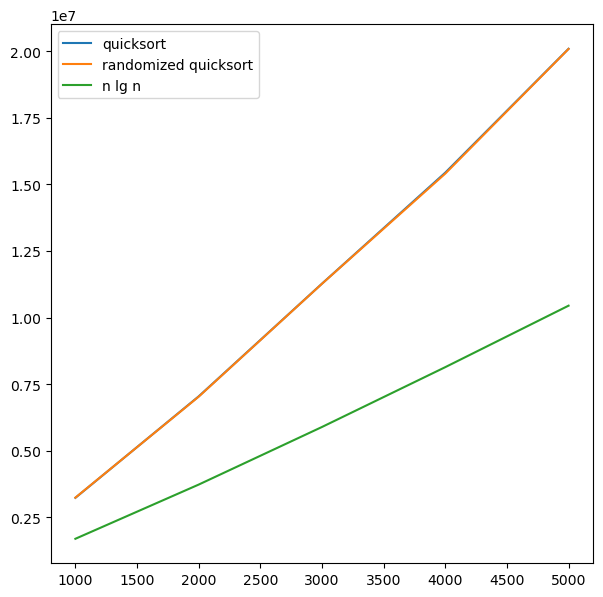

In [17]:
plt.figure(num = 3, figsize=(7, 7))
plt.plot( dim, quickSort_times, label='quicksort')
plt.plot( dim, randomized_quickSort_times, label='randomized quicksort')
plt.plot( dim, nlgn, label='n lg n')
plt.legend(loc="upper left")
plt.show()

Come avevamo previsto si ottiene un andamento dei tempi di esecuzioni assimilabile a $\varTheta(n lg n)$ e i tempi di esecuzione delle due varianti del algoritmo sono praticamente identici.

### Verifica sperimentale dei tempi di esecuzione di Quicksort e Randomized Quicksort nel caso peggiore

In [18]:
dim = [1000, 1100, 1200, 1300, 1400, 1500]

In [19]:
worst_case_quicksort_dataset = generate_unique_dataset(len(dim), 100, dim)
for i in worst_case_quicksort_dataset:
    for j in i:
        j[::-1].sort()

In [20]:
worst_case_randomized_quicksort_dataset = [ [x.copy() for x in worst_case_quicksort_dataset[i]] for i in range(len(worst_case_quicksort_dataset)) ]

In [21]:
worst_case_quickSort_times = benchmark_quickSort(worst_case_quicksort_dataset)

In [22]:
worst_case_randomized_quickSort_times = benchmark_randomized_quickSort(worst_case_randomized_quicksort_dataset)

In [23]:
nquadro = np.array([dim[i]**2*100 for i in range(0, len(dim))])

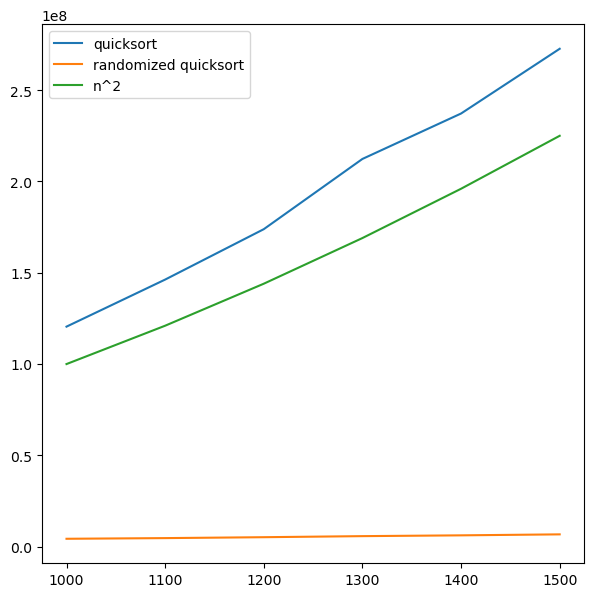

In [24]:
plt.figure(num = 3, figsize=(7, 7))
plt.plot( dim, worst_case_quickSort_times, label='quicksort')
plt.plot( dim, worst_case_randomized_quickSort_times, label='randomized quicksort')
plt.plot( dim, nquadro, label='n^2')
plt.legend(loc="upper left")
plt.show()

In [25]:
df = pd.DataFrame(
    {
        "n": dim,
        "Quicksort": worst_case_quickSort_times,
        "Randomized Quicksort": worst_case_randomized_quickSort_times,
    }
)
df

,n,Quicksort,Randomized Quicksort
0,1000,1.204971e+08,4.320347e+06
1,1100,1.462631e+08,4.687547e+06
2,1200,1.738633e+08,5.184409e+06
3,1300,2.123224e+08,5.766210e+06
4,1400,2.371985e+08,6.200319e+06
5,1500,2.726530e+08,6.736777e+06


A differenza del esperimento precedente qui possiamo vedere come il randomized quicksort performi nettamente meglio riducendo la possibilità di incontrare il caso peggiore e rendendo inoltre impossibile generare appositamente un dataset che metta in difficoltà l'algoritmo.

## Tempo di esecuzione previsto per Insertion sort
Il tempo di esecuzione previsto per l'insertion sort per un array di $n$ elementi è $\varTheta(n^2)$ sia nel caso medio che nel caso peggiore (array ordinato al contrario) e $\varTheta(n)$ nel caso ottimo, ossia quello di un array gia' ordinato.
La sua semplicita' lo rende molto prestante per $n$ molto piccoli, riuscendo anche a battere quicksort, ma allo stesso tempo inutilizzabile per grandi array data la rapidita' con cui cresce il suo tempo di esecuzione.

In [26]:
dim = [10, 20, 30, 40, 50]

In [27]:
insertionSort_dataset = generate_random_dataset(len(dim), 1000, dim)

In [28]:
best_case_insertionSort_dataset = [[x.copy() for x in insertionSort_dataset[i]] for i in range(len(insertionSort_dataset))]
for i in best_case_insertionSort_dataset:
    for j in i:
        j.sort()

In [29]:
worst_case_insertionSort_dataset = [[x.copy() for x in insertionSort_dataset[i]] for i in range(len(insertionSort_dataset))]
for i in worst_case_insertionSort_dataset:
    for j in i:
        j[::-1].sort()

In [30]:
nquadro = np.array([dim[i]**2*50 for i in range(0, len(dim))])

In [31]:
n = np.array([dim[i]*150 for i in range(0, len(dim))])

In [32]:
insertionSort_times = benchmark_insertionSort(insertionSort_dataset)

In [33]:
best_case_insertionSort_times = benchmark_insertionSort(best_case_insertionSort_dataset)

In [34]:
worst_case_insertionSort_times = benchmark_insertionSort(worst_case_insertionSort_dataset)

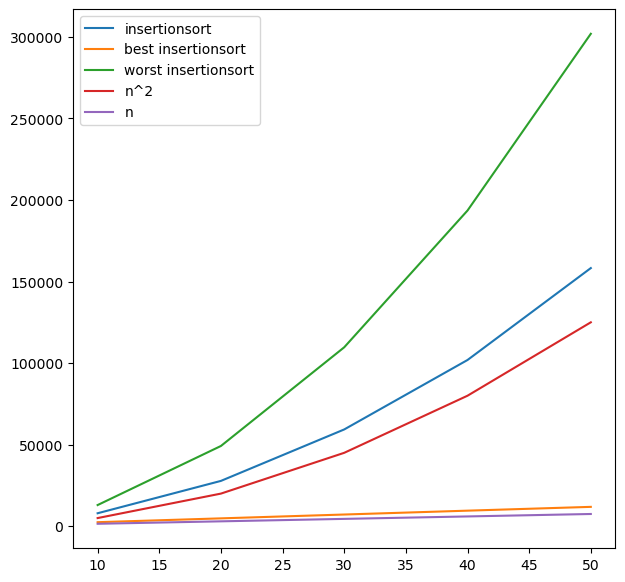

In [35]:
plt.figure(num = 3, figsize=(7, 7))
plt.plot( dim, insertionSort_times, label='insertionsort')
plt.plot( dim, best_case_insertionSort_times, label='best insertionsort')
plt.plot( dim, worst_case_insertionSort_times, label='worst insertionsort')
plt.plot( dim, nquadro, label='n^2')
plt.plot( dim, n, label='n')
plt.legend(loc="upper left")
plt.show()

Come avevamo previsto si ottiene un andamento dei tempi di esecuzioni assimilabili a $\varTheta(n^2)$ nei casi peggiore e medio, mentre $\varTheta(n)$ nel caso migliore

## Confronto tra Quicksort e Insertion sort

Procediamo ora mettendo a confronto le prestazioni di questi due agoritmi. Ci aspettiamo di vedere prestazioni simili su array molto piccoli, con la possibilità che insertionsort sia addirittura più prestante di quicksort data l'estrema semplicità del algoritmo, mentre una netta differenza su array più grandi, con i tempi di quicksort molto inferiori a quelli di insertionsort e un divario sempre maggiore al aumentare delle dimensioni.

### Confronto delle prestazioni su array di piccole dimensioni

In [36]:
dim = [5, 10, 15, 20, 25, 30, 35, 40]

In [37]:
insertionSort_dataset = generate_random_dataset(len(dim), 100000, dim)

In [38]:
quickSort_dataset = [[x.copy() for x in insertionSort_dataset[i]] for i in range(len(insertionSort_dataset))]

In [39]:
insertionSort_times = benchmark_insertionSort(insertionSort_dataset)

In [40]:
quickSort_times = benchmark_quickSort(quickSort_dataset)

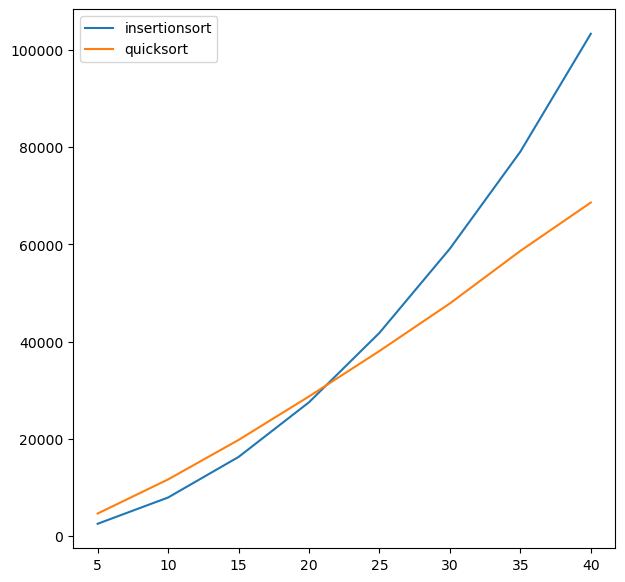

In [41]:
plt.figure(num = 3, figsize=(7, 7))
plt.plot( dim, insertionSort_times, label='insertionsort')
plt.plot( dim, quickSort_times, label='quicksort')
plt.legend(loc="upper left")
plt.show()

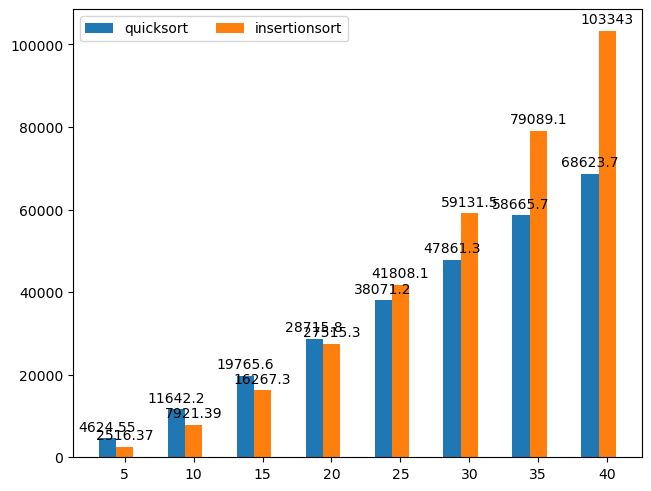

In [42]:
times = {'quicksort' : quickSort_times, 'insertionsort' : insertionSort_times}
x = np.arange(len(dim))
width = 0.25
multiplier = 0
fig, ax = plt.subplots(layout='constrained')
for attributo, valore in times.items():
    offset = width * multiplier
    rects = ax.bar(x+offset, valore, width, label=attributo)
    ax.bar_label(rects, padding = 3)
    multiplier += 1
ax.set_xticks(x + width, dim)
ax.legend(loc='upper left', ncols=3)
plt.show()

Sperimentalmente abbiamo verficato che insertion sort risulta più prestante di quicksort per `n` fino a 20.

### Confronto delle prestazioni su array di grandi dimensioni

In [47]:
dim = [100, 200, 300, 400, 500]

In [48]:
insertionSort_dataset = generate_random_dataset(len(dim), 100, dim)

In [49]:
quickSort_dataset = [[x.copy() for x in insertionSort_dataset[i]] for i in range(len(insertionSort_dataset))]

In [50]:
insertionSort_times = benchmark_insertionSort(insertionSort_dataset)

In [51]:
quickSort_times = benchmark_quickSort(quickSort_dataset)

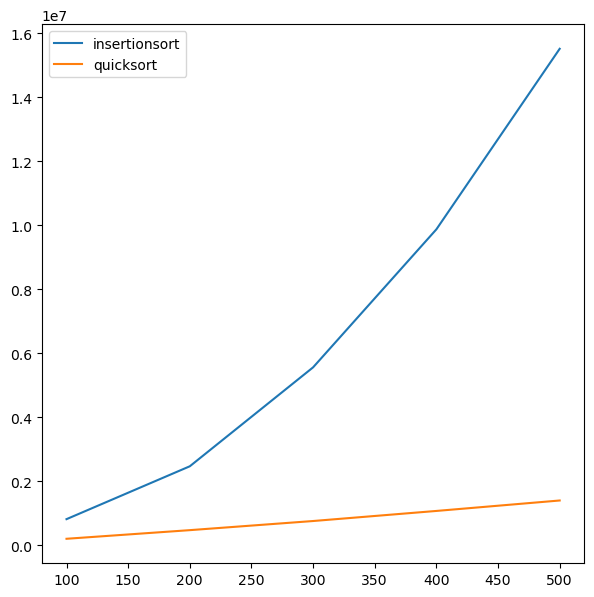

In [52]:
plt.figure(num = 3, figsize=(7, 7))
plt.plot( dim, insertionSort_times, label='insertionsort')
plt.plot( dim, quickSort_times, label='quicksort')
plt.legend(loc="upper left")
plt.show()

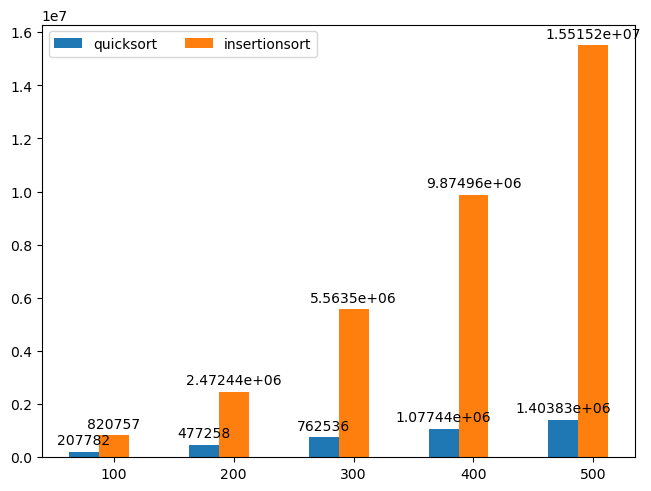

In [53]:
times = {'quicksort' : quickSort_times, 'insertionsort' : insertionSort_times}
x = np.arange(len(dim))
width = 0.25
multiplier = 0
fig, ax = plt.subplots(layout='constrained')
for attributo, valore in times.items():
    offset = width * multiplier
    rects = ax.bar(x+offset, valore, width, label=attributo)
    ax.bar_label(rects, padding = 3)
    multiplier += 1
ax.set_xticks(x + width, dim)
ax.legend(loc='upper left', ncols=3)
plt.show()

Come avevamo verificato anche in precedenza, al aumentare di `n` quicksort risulta molto più prestante di insertionsort.

## Stabilità 

In [69]:
insertionSort_dataset = np.array([4, 2, 2, 1, 5, 3])
print(insertionSort_dataset)

[4 2 2 1 5 3]


In [74]:
for i in range(len(insertionSort_dataset)):
    insertionSort_dataset[i] = np.array(np.array([insertionSort_dataset[i], i]))
print(insertionSort_dataset)

ValueError: setting an array element with a sequence.

## Conslusioni